# Analyzing TF motifs Across Different Alu Elements 

Abin Abraham 
Created: 2018-04-25 15:10:37


* Using ChromHMM enhancers


Alu Elements Analyzed in Su, M. et al.
    - AluYa5
    - AluYb8
    - AluSp
    - AluY
    - AluSc
    - AluSg
    - AluSq
    - AluSx
    - AluJb
    - AluJo

Reference: Su, M. et al., 2014. Evolution of Alu elements toward enhancers. CellReports, 7(2), pp.376–385.

In [3]:
import os, sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [4]:
### FILE PATHS 
ROOT_PATH_chromHMMEnhancer = "/dors/capra_lab/users/abraha1/projects/transposable_elements/data/tf_dynamics/alu_TF_cluster/chromHMM_Alu_intersection"
CHROMHMM_ENHANCER_INTERACTION_FILE={
    "AluJb":"AluJb_chromHMMenhancer_intersect.out",
    "AluJo":"AluJo_chromHMMenhancer_intersect.out",
    "AluSc":"AluSc_chromHMMenhancer_intersect.out",
    "AluSg":"AluSg_chromHMMenhancer_intersect.out",
    "AluSp":"AluSp_chromHMMenhancer_intersect.out",
    "AluSq":"AluSq_chromHMMenhancer_intersect.out",
    "AluSx":"AluSx_chromHMMenhancer_intersect.out",
    "AluYa5":"AluYa5_chromHMMenhancer_intersect.out",
    "AluYb8":"AluYb8_chromHMMenhancer_intersect.out",
    "AluY":"AluY_chromHMMenhancer_intersect.out"}


In [5]:
### LOAD FILE PATHS 
TE_ANALZED = 'AluJo'
df = pd.read_csv(os.path.join(ROOT_PATH_chromHMMEnhancer, CHROMHMM_ENHANCER_INTERACTION_FILE[TE_ANALZED]), sep="\t", header=None, usecols=np.arange(13))


In [6]:
### CLEAN UP DATA
df.columns = ["TF_chr", "TF_start","TF_end", "TF","TE_coordinate",
              "motif_score", "strand", "p_value","q_value","motif_seq","enhancer_chr","enhancer_start","enhancer_end"]

df = df.drop([ "motif_seq", "p_value", "strand"], axis=1)
nodups_df = df.drop_duplicates(subset=['TF','TE_coordinate'], keep=False)


In [7]:
df['enhancer_overlap'] = np.where(df['enhancer_chr'] ==".", False, True);

In [8]:
### PRELIMINARY ANALYSIS 
## histogram of number of TF counts on each instance of TE 
raw_tf_counts = df.groupby(by='TE_coordinate').count()['TF']
unique_tf_counts = nodups_df.groupby(by='TE_coordinate').count()['TF']
TE_carrying_tf = nodups_df.groupby(by='TF').count()['TE_coordinate']

In [9]:
# ## plot
# fig, ax = plt.subplots(1,3)
# _ = ax[0].hist(raw_tf_counts.values, alpha = 0.5, color = 'r')
# _ = ax[0].set_xlabel('# of Raw TF Motifs')
# _ = ax[0].set_ylabel('count')
# _ = ax[0].set_title('# of TF per TE')

# _ = ax[1].hist(unique_tf_counts.values, alpha = 0.5, color = 'g')
# _ = ax[1].set_xlabel('# of Unique TF Motifs');
# _ = ax[1].set_ylabel('count');
# _ = ax[1].set_title('# of unique TF per TE')

# _ = ax[2].hist(TE_carrying_tf.values, alpha = 0.5, color = 'b')
# _ = ax[2].set_xlabel('# of TEs with A Specific TF');
# _ = ax[2].set_ylabel('count');
# _ = ax[2].set_title('# of TEs with a Specific TF')



# plt.tight_layout()
# plt.show()

NOTE: substantial number of rows are dropped when duplicate TE-TF pairs are removed.

In [10]:
### MARK TEs with at least one Enhancer Overlap 
TE_no_enhancer_once =  set(df.loc[df['enhancer_overlap']== False,'TE_coordinate'].unique())
TE_yes_enhancer =  set(df.loc[df['enhancer_overlap']== True,'TE_coordinate'].unique())
TE_with_no_enhancer = TE_no_enhancer_once.difference(TE_yes_enhancer)

len(TE_yes_enhancer)
len(TE_no_enhancer_once)
len(TE_with_no_enhancer)
len(TE_no_enhancer_once.intersection(TE_yes_enhancer))


12907

36755

34164

2591

In [36]:
## GROUPBY

agg_func = {'motif_score':['count','mean','median']}
# nodups_df.groupby(by=['TF','TE_coordinates']).agg(agg_func).swaplevel('TE_coordinates','TF')
# gb_df = nodups_df.groupby(by=['TE_coordinates','TF']).agg(agg_func).reset_index()

# gb_df = nodups_df.groupby(by=['TE_coordinate','TF']).agg(agg_func).unstack(fill_value=0)
gb_df = df.groupby(by=['TE_coordinate','TF']).agg(agg_func).unstack(fill_value=0)
count_gb_df = gb_df['motif_score']['count']

In [37]:
count_gb_df.shape

(47071, 274)

### Heatmap of TF count ### 

In [13]:
import seaborn as sns; sns.set(color_codes=True)

In [38]:
# enhancer_overlap_key
cmap = dict(zip(count_gb_df.index,'r'*len(count_gb_df.index)))

# change those TE with overlap into 'r' 
for this_te in TE_with_no_enhancer: 
    cmap[this_te] = 'b'
    
# NOTE: 'r' will be enhancer overlap, 'b' will be no enhancer overlap at all 

In [39]:
### create column color labels 

row_colors = list()
for this_index in count_gb_df.index: 
    row_colors.append(cmap[this_index])

In [40]:
subset_df = count_gb_df.loc[list(TE_yes_enhancer),:]

In [41]:
subset_df.shape

(12907, 274)

/opt/easybuild/software/Core/Anaconda3/4.3.1/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


RecursionError: maximum recursion depth exceeded while getting the str of an object

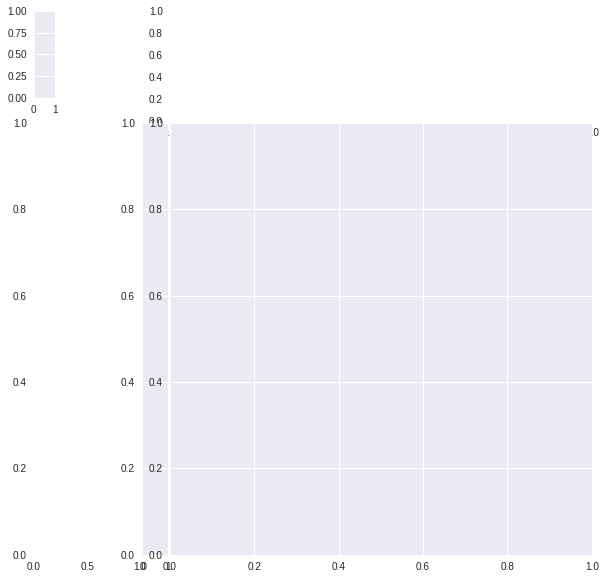

In [45]:
g = sns.clustermap(count_gb_df.iloc[0:2000,:], row_colors=row_colors,method='single' )
_= plt.yticks(rotation=0) 
title_name = "Heirarchical Clustering (Euclidean Dist) of Count of TFs on {}".format(TE_ANALZED)
_= plt.title(title_name, loc='center') 

/opt/easybuild/software/Core/Anaconda3/4.3.1/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text yticklabel objects>)

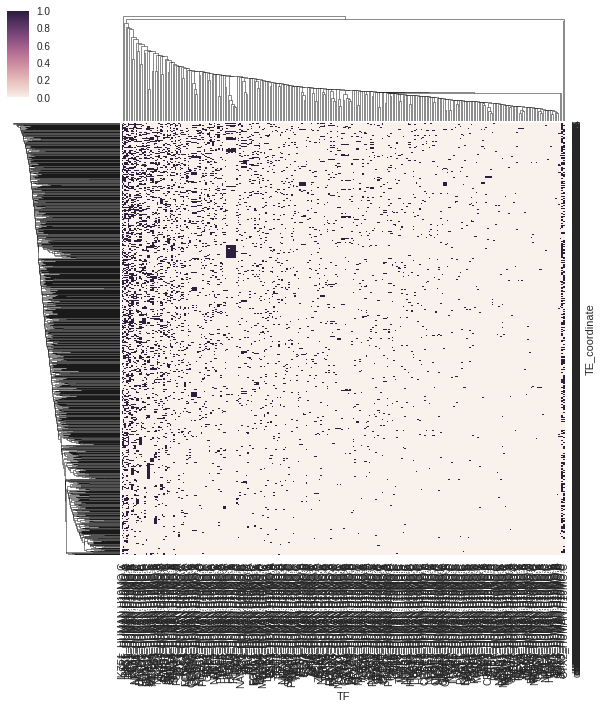

In [18]:
g = sns.clustermap(subset_df.iloc[0:1000,:])
plt.yticks(rotation=0) 
plt.title()


In [19]:
subset_df.iloc[1:10,:]

TF,AHR_HUMAN.H10MO.B,AIRE_HUMAN.H10MO.C,ALX1_HUMAN.H10MO.B,ANDR_HUMAN.H10MO.A,AP2A_HUMAN.H10MO.C,AP2B_HUMAN.H10MO.B,AP2C_HUMAN.H10MO.A,ARI5B_HUMAN.H10MO.C,ARNT_HUMAN.H10MO.B,ATF1_HUMAN.H10MO.B,...,XBP1_HUMAN.H10MO.C,ZEB1_HUMAN.H10MO.B,ZFX_HUMAN.H10MO.C,ZIC1_HUMAN.H10MO.B,ZIC2_HUMAN.H10MO.C,ZIC3_HUMAN.H10MO.C,ZKSC1_HUMAN.H10MO.C,ZN143_HUMAN.H10MO.A,ZN350_HUMAN.H10MO.C,ZN384_HUMAN.H10MO.C
TE_coordinate,,,,,,,,,,,,,,,,,,,,,
chr9:15243628-15243852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr5:157003859-157003959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
chr17:45259535-45259816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
chr8:125483019-125483146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17:74939905-74940088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr8:30634166-30634471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
chr5:16994058-16994341,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr15:77480336-77480636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17:42555071-42555312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate Enrichment of TF

In [35]:
df.shape
unique_tf = df.TF.unique()
len(unique_tf)

(1009361, 11)

274

In [30]:
# subset TE to those that have any overlap with an enhancer

unique_TE_with_enhancers = set(df[df['enhancer_overlap']==True].TE_coordinate)
len(unique_TE_with_enhancers)

enhancer_df = df.loc[df['TE_coordinate'].isin(unique_TE_with_enhancers)]

12907

In [33]:
def calc_OR(dataframe, this_tf):
    true_TF_true_enhancer = dataframe[(dataframe.TF == this_tf) & (dataframe.enhancer_overlap == True)].shape[0]
    true_TF_false_enhancer = dataframe[(dataframe.TF == this_tf) & (dataframe.enhancer_overlap == False)].shape[0]
    false_TF_true_enhancer = dataframe[(dataframe.TF != this_tf) & (dataframe.enhancer_overlap == True)].shape[0]
    false_TF_false_enhancer = dataframe[(dataframe.TF != this_tf) & (dataframe.enhancer_overlap == False)].shape[0]
    odds_ratio = (true_TF_true_enhancer/false_TF_true_enhancer)/(true_TF_false_enhancer/false_TF_false_enhancer)
   
    return odds_ratio

In [41]:
store_OR_enhancers = np.empty([len(unique_tf)])
store_OR = np.empty([len(unique_tf)])



for this_index,this_tf in enumerate(unique_tf): 
    
    odds_ratio = calc_OR(df, this_tf)
    store_OR[this_index] = odds_ratio
    
    odds_ratio_enh = calc_OR(enhancer_df, this_tf)
    store_OR_enhancers[this_index] = odds_ratio_enh
    

In [95]:
### initialize dataframe to hold OR 
series_or = pd.Series(store_OR, index=unique_tf).sort_values()
series_or_enh = pd.Series(store_OR_enhancers, index=unique_tf).sort_values()


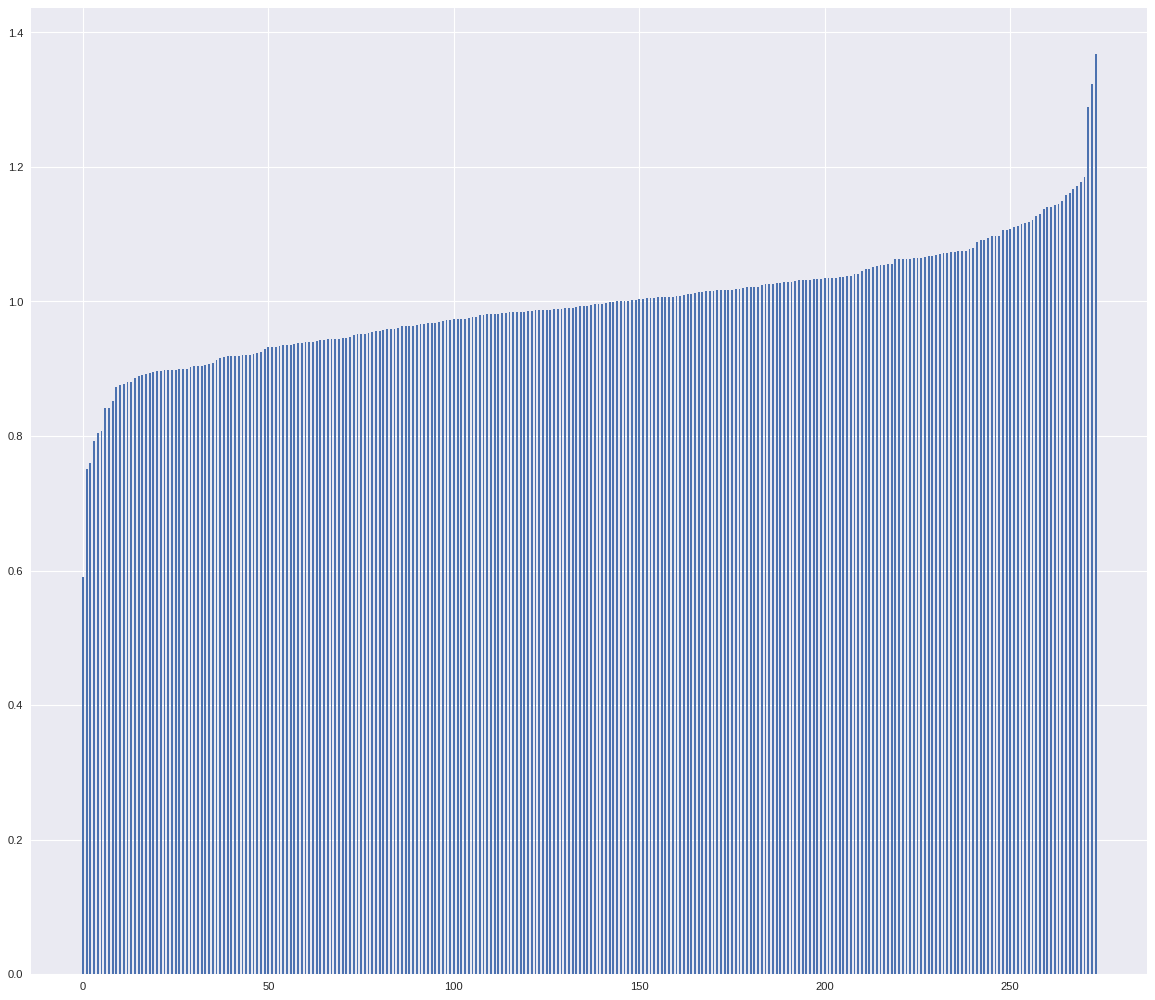

In [96]:
fig, ax = plt.subplots(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
bar_ax = ax.bar(np.arange(len(series_or)), series_or,0.5)


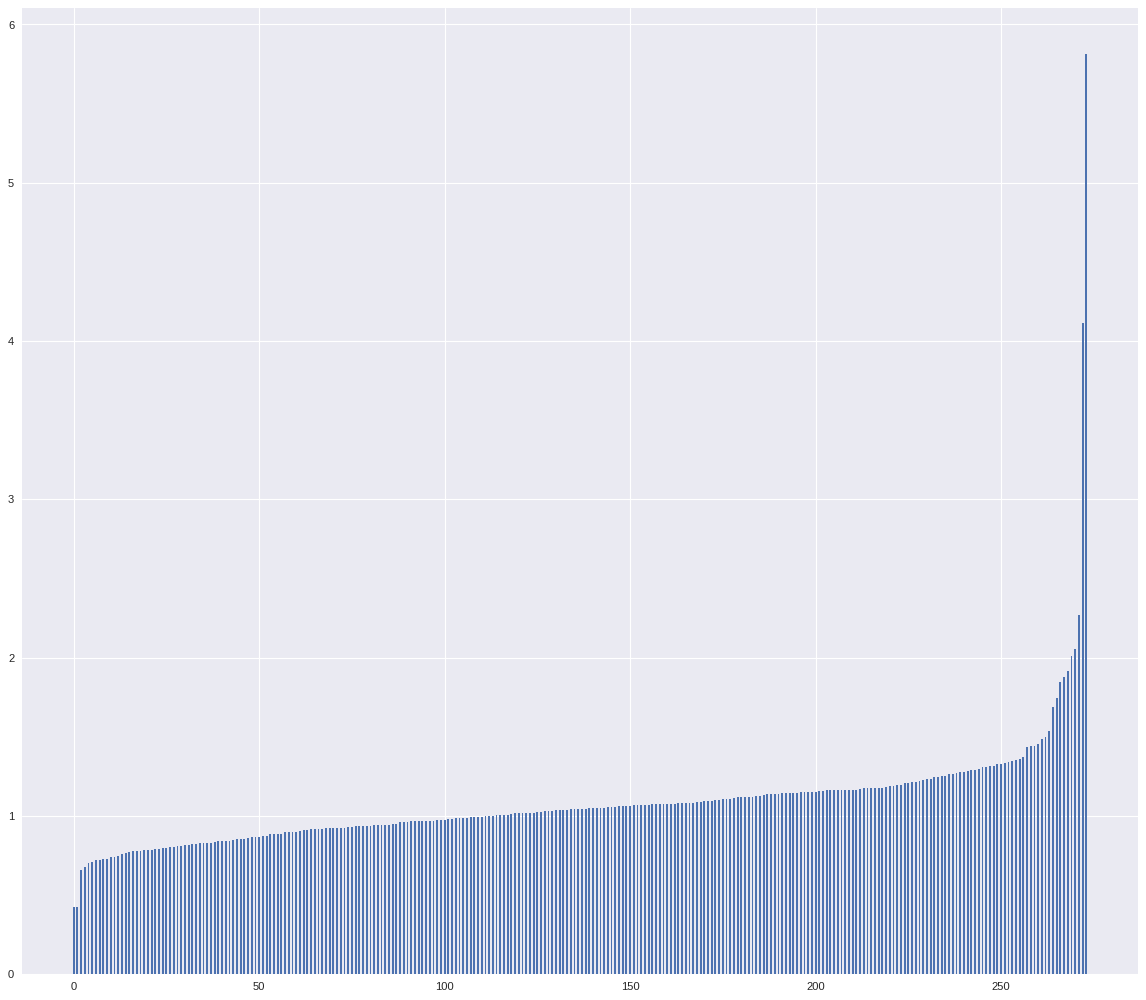

In [97]:
fig, ax = plt.subplots(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
bar_ax = ax.bar(np.arange(len(series_or_enh)), series_or_enh,0.5)


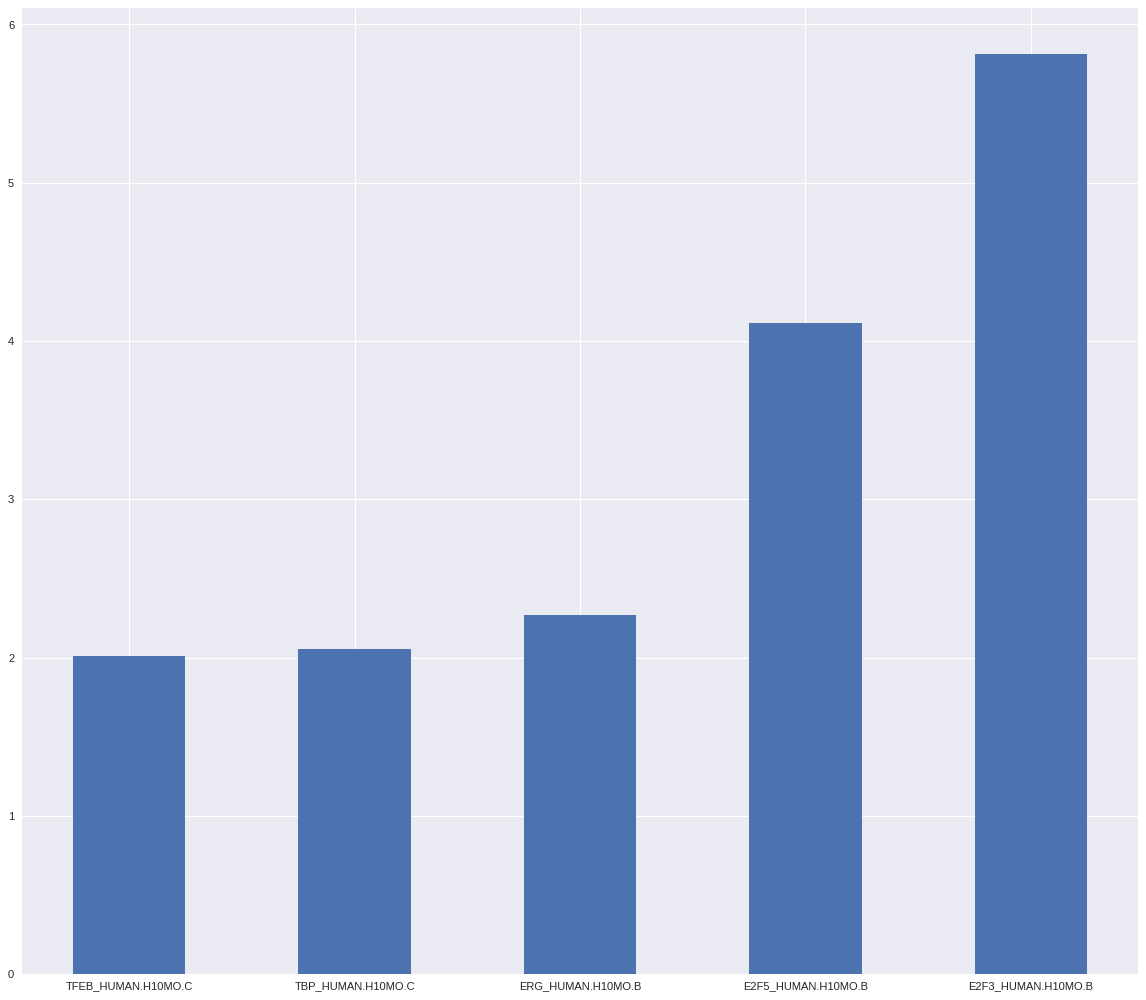

In [93]:
data_to_plot = series_or_enh[series_or_enh > 2]

fig, ax = plt.subplots(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
bar_ax = ax.bar(np.arange(len(data_to_plot)), data_to_plot,0.5)
_ = plt.xticks(np.arange(len(data_to_plot)), data_to_plot.index)

In [104]:
df[df.TF == 'E2F3_HUMAN.H10MO.B']
len(df[df.TF == 'E2F3_HUMAN.H10MO.B'].TE_coordinate)
set(df[df.TF == 'E2F3_HUMAN.H10MO.B'].TE_coordinate)


,TF_chr,TF_start,TF_end,TF,TE_coordinate,motif_score,q_value,enhancer_chr,enhancer_start,enhancer_end,enhancer_overlap
320191,chr11,118766434,118766444,E2F3_HUMAN.H10MO.B,chr11:118766156-118766467,12.7207,0.000079,chr11,118765390,118768390,True
320192,chr17,63175527,63175537,E2F3_HUMAN.H10MO.B,chr17:63175290-63175555,12.7207,0.000079,chr17,63166338,63182738,True
320193,chr1,182319083,182319093,E2F3_HUMAN.H10MO.B,chr1:182318927-182319209,12.7207,0.000079,chr1,182317377,182319977,True
320194,chr2,44315497,44315507,E2F3_HUMAN.H10MO.B,chr2:44315367-44315675,12.7207,0.000079,chr2,44314096,44316096,True
320195,chr3,12137219,12137229,E2F3_HUMAN.H10MO.B,chr3:12136968-12137265,12.7207,0.000079,.,-1,-1,False
320196,chr3,50597117,50597127,E2F3_HUMAN.H10MO.B,chr3:50596840-50597140,12.7207,0.000079,.,-1,-1,False
320197,chr7,99542949,99542959,E2F3_HUMAN.H10MO.B,chr7:99542672-99542983,12.7207,0.000079,chr7,99540464,99543464,True
320198,chr8,117857533,117857543,E2F3_HUMAN.H10MO.B,chr8:117857411-117857716,12.7207,0.000079,.,-1,-1,False
320199,chr9,35955290,35955300,E2F3_HUMAN.H10MO.B,chr9:35955260-35955331,12.7207,0.000079,.,-1,-1,False
320200,chr9,71731619,71731629,E2F3_HUMAN.H10MO.B,chr9:71731455-71731747,12.7207,0.000079,.,-1,-1,False


136

{'chr10:104374178-104374480',
 'chr10:11930496-11930787',
 'chr10:14149348-14149668',
 'chr10:21692487-21692786',
 'chr10:22118939-22119235',
 'chr10:25144954-25145070',
 'chr10:26961563-26961695',
 'chr10:46673505-46673740',
 'chr10:47668310-47668545',
 'chr10:60113428-60113725',
 'chr10:87129663-87129898',
 'chr10:92394744-92394859',
 'chr11:107624370-107624592',
 'chr11:117149183-117149381',
 'chr11:118766156-118766467',
 'chr11:124674231-124674340',
 'chr11:59832506-59832646',
 'chr11:82856024-82856157',
 'chr12:132711506-132711801',
 'chr12:132757401-132757540',
 'chr12:39961506-39961800',
 'chr12:53154976-53155093',
 'chr12:67251802-67252101',
 'chr12:853759-854050',
 'chr12:96237290-96237375',
 'chr13:39625035-39625318',
 'chr13:41579843-41580154',
 'chr13:91246137-91246225',
 'chr13:99107531-99107773',
 'chr14:24909499-24909655',
 'chr14:46073594-46073891',
 'chr14:49596779-49596906',
 'chr14:90613114-90613412',
 'chr14:91978975-91979273',
 'chr15:42618156-42618432',
 'chr15:58

### Spectral Biclustering ### 


In [14]:
from sklearn.cluster.bicluster import SpectralBiclustering

In [15]:
data = gb_df.iloc[0:822,0:822].as_matrix()

In [20]:
data.shape

(822, 822)

In [98]:
n_clusters = 10
model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',random_state=0)
model.fit(data)

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]


plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.show()

NameError: name 'SpectralBiclustering' is not defined